# Import the Prepared Data

In [1]:
import pandas as pd

src= "C:\\Users\\samue\\Downloads\\research_project\\VAE\\prepped_data.csv"
df = pd.read_csv(src)

df.head(10)

,Unnamed: 0,Unnamed: 0.1,Amino Acids,phi,psi,Coded_AA,scaled_phi,scaled_psi
0,0,0,ALA,NaN,2.833464,0.000000,0.000000,0.950972
1,1,1,ALA,-2.637405,2.960152,0.000000,0.079848,0.971136
2,2,2,ALA,-1.349753,2.491088,0.000000,0.284933,0.896479
3,3,3,ALA,-1.612154,-0.667668,0.000000,0.243140,0.393728
4,4,4,GLY,2.514027,-2.779758,0.409091,0.900319,0.057566
5,5,5,SER,-2.216942,2.486409,0.772727,0.146816,0.895735
6,6,6,VAL,-1.590854,-0.109528,0.954545,0.246533,0.482563
7,7,7,TRP,-1.795117,-0.296301,0.863636,0.214000,0.452836
8,8,8,GLY,-1.784287,1.648929,0.409091,0.215725,0.762440
9,9,9,ALA,-0.932471,-0.573457,0.000000,0.351394,0.408723


# Create a formatted Torch Tensor and Shuffle the 1142 structures randomly

In [2]:
import torch
import torch.utils.data
from torch import nn, optim

#reshape the data into (#structures,#channels,#amino_acids) = [1142,1,44]
#this will ensure propper reshape latter on
Amino_Acids = torch.tensor([df.iloc[:,[5]].values])
Amino_Acids = torch.reshape(Amino_Acids, (1142,1,44))
phi = torch.tensor([df.iloc[:,[6]].values])
phi = torch.reshape(phi, (1142,1,44))
psi = torch.tensor([df.iloc[:,[7]].values])
psi = torch.reshape(psi, (1142,1,44))

#cat concatenates the tensors into the given dimension here the dim is the channel dim
LOAD_DATA = torch.cat((Amino_Acids,phi,psi),1)
print(LOAD_DATA.shape)

MIXED_DATA = LOAD_DATA
# shuffle all the 1142 3channel44length input structures
# MIXED_DATA = LOAD_DATA[torch.randperm(LOAD_DATA.size()[0])]
# print("After Mixing shape:", MIXED_DATA.shape)
# print(LOAD_DATA[0][0][0:5],MIXED_DATA[0][0][0:5])

ModuleNotFoundError: No module named 'torch'

# Seperate the Train and Test data: 90/10

In [124]:
#seperate training and testing data
VAL_PCT = 0.1
val_size = int(MIXED_DATA.size()[0]*VAL_PCT) #use the size of the first dim(the # of structures to split 10%/90%)

train_X =MIXED_DATA[:-val_size]
test_X = MIXED_DATA[-val_size:]

In [125]:
print("train shape: ",train_X.shape,"test shape: ",test_X.shape)

train shape:  torch.Size([1028, 3, 44]) test shape:  torch.Size([114, 3, 44])


# Implement the Convolutional VAE

In [126]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm


#----------------------------------------HYPER-PARAMS--------------------------------------------------------#
batch_size=16
epochs=20
cuda=False
seed=1

cuda = not cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(seed)

#----------------------------------------VAE--------------------------------------------------------#
#inspired by:https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            #conv1d(in_shape,out_shape,conv_kernels)
            nn.Conv1d(3, 32, kernel_size=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4),
            nn.ReLU()
        )
        
        # the linear layer inputs were determined from the conv output of: [16,64,9] where 64*9=576
        self.fc1 = nn.Linear(2432, 16)
        self.fc2 = nn.Linear(2432, 16)
        self.fc3 = nn.Linear(16, 2432) #this one is for decoding
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=4),
            nn.Sigmoid()
        )

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0),-1) #flattening
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0),64,38) #unflattening
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
#----------------------------------------VAE-END--------------------------------------------------------#
    
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#----------------------------------------LOSS/TRAIN/TEST--------------------------------------------------------#
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0

    for i in tqdm(range(0, len(train_X), batch_size)):
        batch_X = train_X[i:i+batch_size] #grab the batch
        batch_X = batch_X.float()
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch_X)
        
        loss = loss_function(recon_batch, batch_X, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / 1142))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i in tqdm(range(0, len(test_X) )): #no longer need to do batches
            batch_X = test_X[i].view(1,3,44) #grab the batch
            batch_X = batch_X.float()
            batch_X = batch_X.to(device)
            recon_batch, mu, logvar = model(batch_X)
            test_loss += loss_function(recon_batch, batch_X, mu, logvar).item()
            

    test_loss /= len(test_X)
    print('====> Test set loss: {:.4f}'.format(test_loss))
#----------------------------------------(LOSS/TRAIN/TEST)-END--------------------------------------------------------#
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        

 18%|█▊        | 12/65 [00:00<00:00, 117.21it/s]

====> Epoch: 1 Average loss: 63.2441
====> Test set loss: 60.6213


 17%|█▋        | 11/65 [00:00<00:00, 109.33it/s]

====> Epoch: 2 Average loss: 48.0993
====> Test set loss: 55.3053


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 45.8749
====> Test set loss: 55.0328


 17%|█▋        | 11/65 [00:00<00:00, 109.84it/s]

====> Epoch: 4 Average loss: 45.0114
====> Test set loss: 53.0010


 18%|█▊        | 12/65 [00:00<00:00, 119.27it/s]

====> Epoch: 5 Average loss: 44.6713
====> Test set loss: 52.8610


 18%|█▊        | 12/65 [00:00<00:00, 119.23it/s]

====> Epoch: 6 Average loss: 44.1765
====> Test set loss: 53.1289


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 43.7417
====> Test set loss: 52.6539


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 43.4818
====> Test set loss: 52.1196


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 42.9907
====> Test set loss: 51.6827


 20%|██        | 13/65 [00:00<00:00, 121.54it/s]

====> Epoch: 10 Average loss: 42.8186
====> Test set loss: 51.7806


 18%|█▊        | 12/65 [00:00<00:00, 111.36it/s]

====> Epoch: 11 Average loss: 42.6219
====> Test set loss: 51.1877


 17%|█▋        | 11/65 [00:00<00:00, 109.47it/s]

====> Epoch: 12 Average loss: 42.1772
====> Test set loss: 51.0242


 17%|█▋        | 11/65 [00:00<00:00, 107.79it/s]

====> Epoch: 13 Average loss: 41.9962
====> Test set loss: 50.5431


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 14 Average loss: 41.7179
====> Test set loss: 50.2569


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 15 Average loss: 41.6190
====> Test set loss: 50.5050


 15%|█▌        | 10/65 [00:00<00:00, 96.89it/s]

====> Epoch: 16 Average loss: 41.5732
====> Test set loss: 50.3057


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 17 Average loss: 41.5315
====> Test set loss: 49.8787


  0%|          | 0/65 [00:00<?, ?it/s]

====> Epoch: 18 Average loss: 41.1958
====> Test set loss: 50.2695


 20%|██        | 13/65 [00:00<00:00, 118.29it/s]

====> Epoch: 19 Average loss: 41.5156
====> Test set loss: 50.0282


100%|██████████| 114/114 [00:00<00:00, 1200.39it/s]

====> Epoch: 20 Average loss: 41.3810
====> Test set loss: 49.7771


# Print out a sample from the latent space and check the results

In [127]:
with torch.no_grad():
#     sample = torch.randn(1, 16).to(device) #this is the current shape of the lattent space for batches of 1
    sample = test_X[0].float().view(1,3,44)
    sample, mu, logvar = model.encode(sample)
    sample = model.decode(sample).cpu()
    print(sample.shape)
df_out = pd.DataFrame({"AA":test_X[0][0],"phi":test_X[0][1],"psi":test_X[0][2],"decoded_AA":sample[0][0],"decoded_phi":sample[0][1],"decoded_psi":sample[0][2]})

torch.Size([1, 3, 44])


# Since the input to the latent space was random, the result will not be good

In [128]:
#if the inputs are not random the test_X should correspond to the structure found at row 45232 in the prepped_data excel file
df_out

,AA,phi,psi,decoded_AA,decoded_phi,decoded_psi
0,0.772727,0.000000,0.950876,0.394411,0.010200,0.644614
1,0.681818,0.680659,0.351397,0.562589,0.303928,0.597150
2,0.409091,0.266307,0.593341,0.549786,0.340138,0.571380
3,0.545455,0.218300,0.489069,0.385565,0.269737,0.548632
4,0.227273,0.036527,0.070271,0.474248,0.282619,0.524657
5,0.045455,0.690544,0.331210,0.488924,0.297017,0.549171
6,0.545455,0.658091,0.310984,0.465320,0.302121,0.543996
7,0.045455,0.098858,0.354551,0.495860,0.306751,0.495955
8,0.045455,0.199266,0.520113,0.471378,0.314326,0.503505
9,0.409091,0.271484,0.909011,0.394323,0.288743,0.491342


<AxesSubplot:>

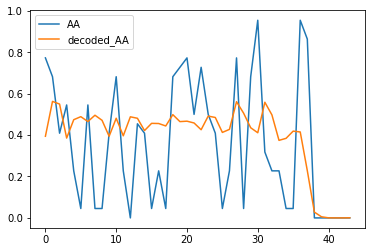

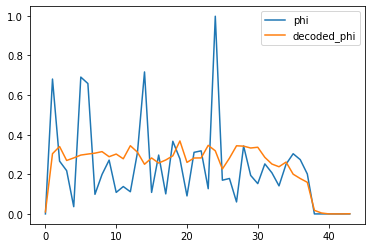

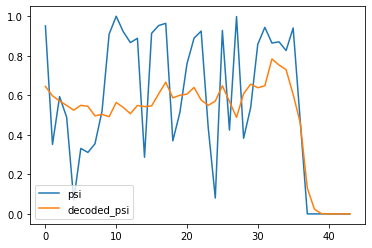

In [129]:
df_out.plot(y=(['AA','decoded_AA']))
df_out.plot(y=(['phi','decoded_phi']))
df_out.plot(y=(['psi','decoded_psi']))

In [ ]:
################USED THIS TO MAKE SURE THE TENSOR SHAPES WORKED################
import torch.nn.functional as F

m = nn.Conv1d(3, 32, kernel_size=4)
n = nn.Conv1d(32, 64, kernel_size=4)

linear1 = nn.Linear(2432, 16)
linear2 = nn.Linear(2432, 16)

linear3 = nn.Linear(16, 2432)

o = nn.ConvTranspose1d(64, 32, kernel_size=4)
p = nn.ConvTranspose1d(32, 3, kernel_size=4)

sigmoid = nn.Sigmoid()

def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z



input = torch.randn(16,3,44)
print("input to conv1d",input.shape)
output = m(input)
output = n(output)
output = (F.relu(output))
print("POST CONV's",output.shape)
output = output.view(output.size(0),-1)
print("POST VIEW output",output.shape)

#reparametrize
mu, logvar = linear1(output), linear2(output)
print("POST LINEAR mu",mu.shape)
z = reparameterize(output,mu, logvar)
print("POST REPARAMETRIZING Z",z.shape)

print("Done the endoding ! ","Z:",z.shape,"mu:",mu.shape,"logvar:",logvar.shape)
print("\n","now decoding")
#decoding
z = linear3(z)
print("POST LINEAR mu",mu.shape)
z = z.view(z.size(0),64,38)
print("POST UNFLATTEN z",z.shape)
z = o(z)
z = p(z)
print("POST CONV's",z.shape)
z = sigmoid(z)
print("POST SIGMOID! :",z.shape)
print("FINISHED THE PASS THROUGH!")
